# Assignment 1: Feature analysis

Check that an older version of numpy is being used by the system since numpy versions past 2.00 cause mlxtend due to some NPN metrics

In [87]:
import numpy as np
print(np.__version__)

2.1.1


## Load Dataset

Load the dataset from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized saved as a csv file "CommViolPredUnnormalizedData.csv". The dataset has 147 features of which; 125 predictive, 4 non-predictive, 18 potential goal features. The goal feature to be taken is the assultPerPop feature which describes the number of assaults per 100,000 population.

In [88]:
# Importing pandas for loading the dataset and data manipulation
import pandas as pd

# Load Dataset
dataset = pd.read_csv("CommViolPredUnnormalizedData.csv", header=0)

# Get the shape of the dataset
print("Dataset Raw Shape:", dataset.shape)

# Print the headers to inspect them
print("Dataset Headers:", dataset.columns.tolist())

Dataset Raw Shape: (2215, 148)
Dataset Headers: ['Unnamed: 0', 'communityname', 'state', 'countyCode', 'communityCode', 'fold', 'population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumKidsBornNeverMar', 'PctKidsBornNeverMar', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImm

## 1. Data cleaning, missing data and normalization
### Drop Non-Predictive and Goal Columns
Remove the columns that are not predictive or are potential goals that arent the target column. The working dataset should only contain predictive features and the target column.

In [89]:
# Define a list of non-predictive headers
non_predicitive_headers = ['communityname', 'countyCode', 'communityCode', 'fold']

# Define a list of potential goal headers
goal_headers = ['murders', 'murdPerPop', 'rapes', 'rapesPerPop', 'robberies', 'robbbPerPop', 'assaults', 'burglaries', 'burglPerPop', 'larcenies', 'larcPerPop', 'autoTheft', 'autoTheftPerPop', 'arsons', 'arsonsPerPop', 'ViolentCrimesPerPop', 'nonViolPerPop']

# Combine both lists of headers and also drop the index column from the csv format
headers_to_drop = ['Unnamed: 0'] + non_predicitive_headers + goal_headers

# Check if the headers exist in the dataset if not dont add them to the drop list as they will throw an error
headers_to_drop = [header for header in headers_to_drop if header in dataset.columns]

# Drop the columns
dataset.drop(columns=headers_to_drop, inplace=True)

# Print the shape of the dataset after dropping columns
print("Dataset Shape after dropping columns:", dataset.shape)

Dataset Shape after dropping columns: (2215, 126)


### Handeling of Non-Numeric Features

The non-numeric features can not be processed noramally through mathematical operations that we require, such as normalization, so we need to convert them to a numeric format.

For the state we are able to use a dictionary to map each unique state to a unique numeric value without influencing the prediction since it is a category identifier.

For the other non-numeric features we can use one-hot encoding to convert them to a numeric format.

In [90]:
# Replace missing values indicated by '?' with np.nan values
dataset = dataset.replace('?', np.nan)
# Note this is done here to avoid errors when converting to numeric but will also be needed for imputation

# Print the non-numeric features
print("Non-Numeric Features:", dataset.select_dtypes(exclude='number').columns.tolist())

# Get the unique instances of the state column
states = dataset['state'].unique()

# Create a dictionary for each unique state and its corresponding numeric value
state_dict = {state: i for i, state in enumerate(states)}

# Map the state column to the dictionary
dataset['state'] = dataset['state'].map(state_dict)

# Convert the dataset to a numeric format
dataset = dataset.apply(pd.to_numeric)

# Check if all features are numeric
print("All Features are Numeric:", dataset.select_dtypes(exclude='number').empty)


Non-Numeric Features: ['state', 'OtherPerCap', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'PolicBudgPerPop', 'assaultPerPop']
All Features are Numeric: True


### Handeling Missing Values 

1. Remove rows/columns with missing values. It is a simple implementation but can lead to a lot of data loss if there are many missing data occurances.

2. Foward or Backward Filling is the method of using previous or next column values (respectively). It is typicaly useful for sequential data.

3. Imputation is the filling of data using statistical methods such as the mean, median or mode. Simple to implement without loss of data. However, may cause heavy biases if the data is not randomly missing.

4. Specified Algorthimns in the machine learning algorithm can handle the case of missing values. Being specific to the algorithmn can come as a advantage and a constraint.

**Evaluation**

Dropping the rows with missing values resulted in too many rows being removed. Causing the dataset to be reduced from 2215 rows to 337 rows. This is a significant loss of data and will result in a less accurate model.


    Dataset Shape before dropping rows with missing values: (2215, 126)
    
    Dataset Shape after dropping rows with missing values: (337, 126)

Given the large proportion of missing values and the presence of consecutive gaps, forward or backward filling would not effectively address the gaps and could introduce biases in the dataset.
    
**Chosen Method** 

A hybrid approach of dropping columns that are heavy with missing values and imputing the remaining missing values was chosen to handle the missing values in the dataset. This approach seemed fit as it eliminated the bias that would have been introduced by imputing the heavy missing columns.

In [91]:

#  Import the SimpleImputer class
from sklearn.impute import SimpleImputer

# Print the number of missing values in the dataset
print("Number of missing values in the dataset:", dataset.isnull().sum().sum())

# Print the shape before dropping missing heavy columns
print("Dataset Shape before dropping missing heavy columns:", dataset.shape)

# Drop columns with more than 50% missing values
dataset.dropna(thresh=0.5*dataset.shape[0], axis=1, inplace=True)

# Print the shape after dropping missing heavy columns
print("Dataset Shape after dropping missing heavy columns:", dataset.shape)

# Check for any remaining missing values
print("Number of missing values after dropping missing heavy columns:", dataset.isnull().sum().sum())

# Initialize the SimpleImputer with mean strategy
imputer = SimpleImputer(strategy='mean')

# Apply the imputer using fit_transform on the dataset for the remaining missing values
dataset = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)

# Check for any remaining missing values
print("Number of missing values after imputation: ", dataset.isnull().sum().sum())


Number of missing values in the dataset: 41198
Dataset Shape before dropping missing heavy columns: (2215, 126)
Dataset Shape after dropping missing heavy columns: (2215, 104)
Number of missing values after dropping missing heavy columns: 14
Number of missing values after imputation:  0


### Normalize the Dataset

Normalization transforms the data to a specific range or distribution, making it easier for machine learning algorithms to process. It ensures that each feature contributes equally to the model, preventing features with larger ranges from dominating the learning process. This is crutial in algorithmns such as the gradient-decent.

1. Min-Max Scaling transforms the data to a range [0,1] with a simple formulea. This preserves the relation between data and points on grapichal representations. However, it is sensitive to outlires that may come outside the original min/max.

2. Standardization transforms the data to have a mean of 0 and a standard deviation of 1. It is effective for algorithms that assume normally distributed data but is also sensitive to outliers.

3. Robust Scaling uses the median and interquartile range for scaling. This fixes the problem of outliers but makes it suffer from data that is not symettrically distributed.

4. Max Abs Scaling, scales each feature by its maximum absolute value. Particularly useful for data that is already centered at zero but does not handle outliers well either.

*** Evalutation ***

When testing using both Min-Max scaling and Standard Scalar. I noted a significant difference in the compared MSE values. This was due to the different scaling ranges of the two methods. Min-Max scales to a 0-1 range whilst StandardScaler scales to a mean of 0 and a standard deviation of 1. So although the Min-Max seemed to have better MSE values, it was not magnitudes better but rather a scaling difference.

*** Chosen Method ***

Standard Scalar normalization was chosen due to the varience of scaling between the features and its function of having mean 0 and variance 1, seemed fitting for the dataset.


In [92]:
# Import the StandardScaler class
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the dataset
norm_dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)

# Print the head of the dataset
norm_dataset.head()

target = norm_dataset['assaultPerPop']
features = norm_dataset.drop(columns=['assaultPerPop'])

## 2. Filter methods

### Colour Coded Correlation Matrix

Using pandas defined .corr() function to calculate the correlation matrix of the numeric columns in the dataset. We are easily able to see the correlation between the features in the dataset. These are then plotted using matplotlib and seaborn to create a heatmap of the correlation matrix. This allows us to easily see the correlation between the features in the dataset.

We note the diagonal line of correlation of 1.0 as expected due to the feature being correlated with itself

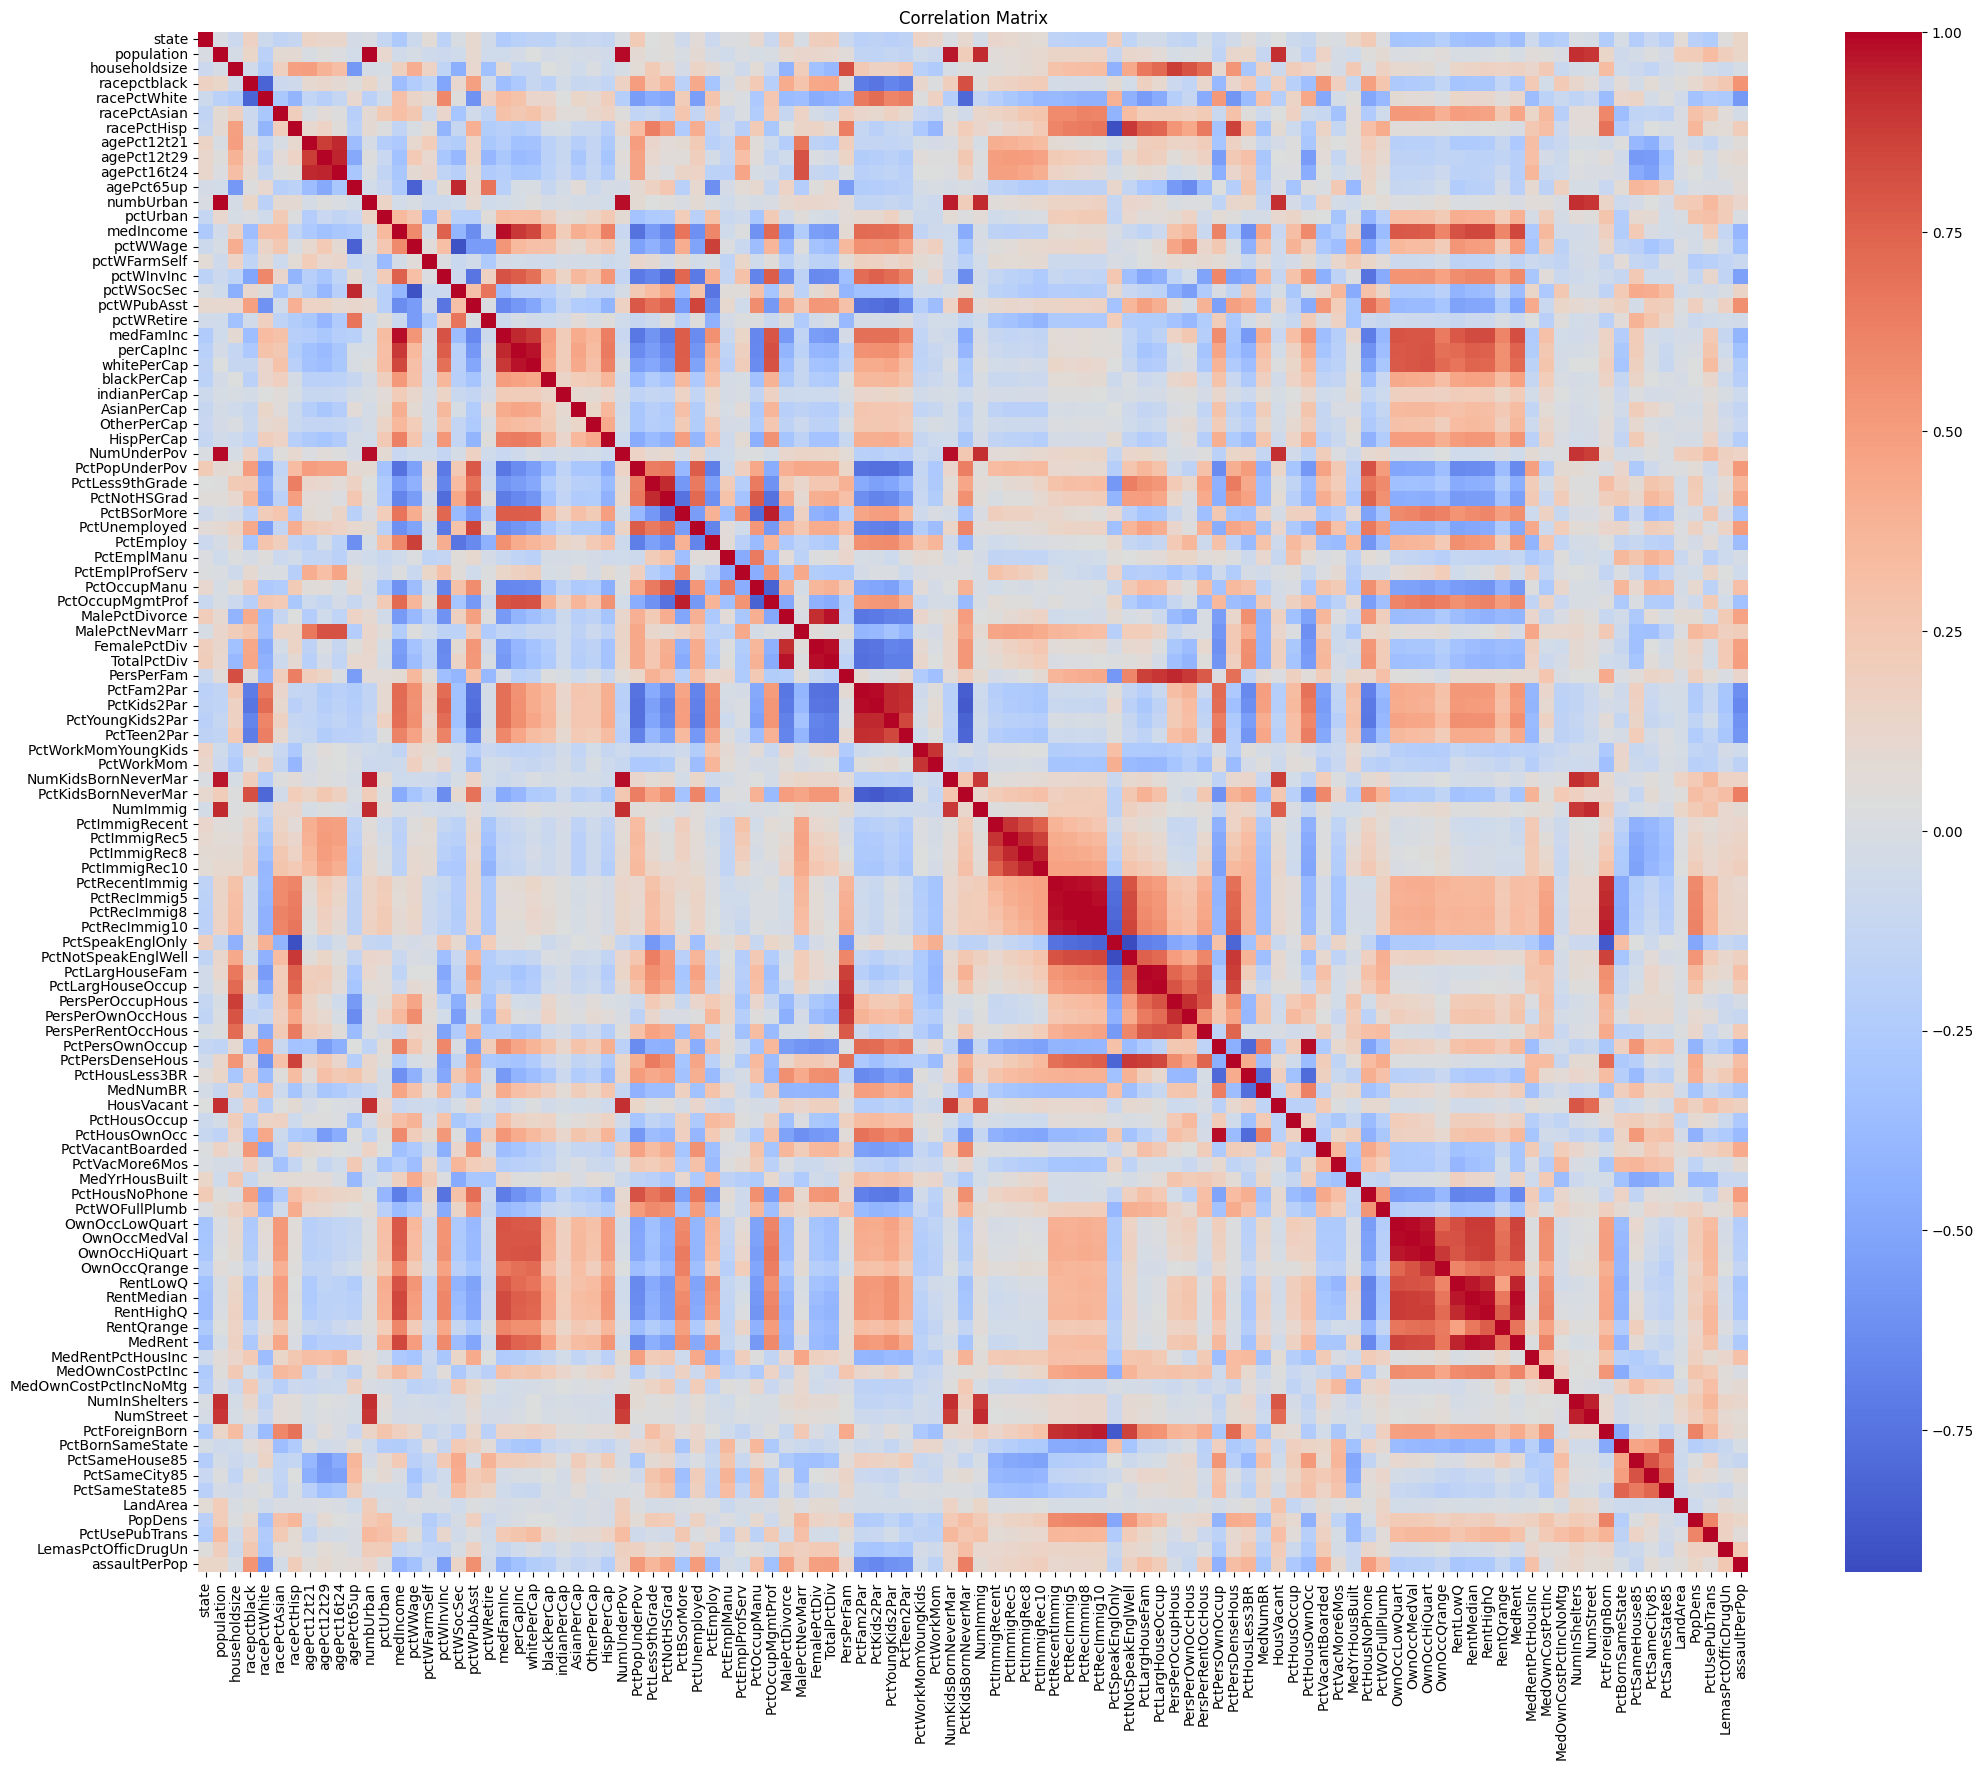

In [93]:
# Import the matplotlib and seaborn libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set the goal feature as the correlation target
target_id = 'assaultPerPop'

# Define the correlation matrix
correlation_matrix = norm_dataset.corr()

# Plot the heatmap
plt.figure(figsize=(25, 20))
# Sns heatmap with correlation matrix, with cmap as coolwarm, so red is positive, blue is negative
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix")
plt.show()



### Selecting a Correlation Threshold

When we calculated the correlation matrix, we found the index of mutual information between all the features. Now we will use this index to select the features that have are highly correlated with the target feature.

1. Visually inspect the correlation matrix and select a threshold that makes sense based off the heatmap and the correlation values.

2. Knowing the area/domain of the data and the features, select a threshold that makes sense. So if police where to look at the dataset they could identify the features that are highly correlated with each other and select a threshold that makes sense.

3. Use common statistical thresholds, so between -1 and 1, a correlation of 0.7 is considered high, 0.5 is moderate and 0.3 is low. So you can select a threshold of 0.5 for example. These values have statistical significance and are commonly.

4. Itersatively select a threshold and evaluate the model's performance. So you can start with a threshold of 0.5 and evaluate the model's performance, then increase or decrease the threshold and evaluate the model's performance again. This is a trial and error method but it is effective.

A moderate correlation threshold of 0.5 is used to select the features. This is mainly due to the fact that higher could not be used as there wouldn't be any dtypes left to select.

In [94]:
# Select features based on a correlation threshold
correlation_threshold = 0.5

# Select the features based on the correlation absolute threshold value, that is taking both negative and positive scales
selected_features = correlation_matrix.index[correlation_matrix[target_id].abs() > correlation_threshold].tolist()

# Remove the target feature from the selected features
selected_features.remove(target_id)  

# Print the amount of selected features
print("Number of Selected Features from Correlation Threshold:", len(selected_features))

Number of Selected Features from Correlation Threshold: 12


### Train-Test Split

The dataset must now be split into training and testing sets. The training set is used to train the model, while the testing set is used to evaluate the model's performance. It is vital that there is no data leakage between the sets or else the model performance will be overestimated.

The split ratio is chosen arbitrarily and can be to the size of training or testing wanted. However, when building models, it is common to use an 80/20 or 70/30 split. In this case, we will use an 80/20 split. It is important to train on more data than testing to ensure the model is robust.

After splitting the normalized dataset. We can get the selected sets from the features chosen based on the correlation threshold. The selected features training set is then fitted to the model, and the testing set is used to evaluate the model's performance.

In [95]:
# Import the train_test_split function
from sklearn.model_selection import train_test_split


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Get the selected features for training and testing
X_train_flt = X_train[selected_features]
X_test_flt = X_test[selected_features]

# Print the size of the training and testing sets
print("Training Set Size:", X_train.shape)
print("Testing Set Size:", X_test.shape)
print("-------------------------")
print("After Feature Selection")
print("Training Set Size:", X_train_flt.shape)
print("Testing Set Size:", X_test_flt.shape)



Training Set Size: (1772, 103)
Testing Set Size: (443, 103)
-------------------------
After Feature Selection
Training Set Size: (1772, 12)
Testing Set Size: (443, 12)


### Training Neural Network for Prediction

The MLPRegressor class is a predictive model used to predict continuous values. Unlike MLPClassifier, which is used for classification tasks. We initialize the regressor with base parameters as the filter method should not take too many computational resources. 

In [96]:
# Import the MLPRegressor class
from sklearn.neural_network import MLPRegressor

# Initialize the MLPRegressor 
mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Fit the model on the training data
mlp_flt = mlp.fit(X_train_flt, y_train)

# Predict the target feature on the test data
y_pred_flt = mlp_flt.predict(X_test_flt)


### Evaluate Model

The sklearn library provides a mean_squared_error function to compute the MSE between the actual and predicted values.

The lower the MSE the better the model is performing. Keeping in mind the scalling of normalized data due to the StandardScaler, the MSE value should be close to 1.0 or less for a good model.

In this case, the MSE value is 0.43337 which is a very good value for the model and we may see the other models find it hard to improve this value significantly further. 

A plot of the actual vs predicted values is also displayed. This can give us a visual representation of how close to perfect correlation the model is operating. The closer the points are to the red line, the better the model is performing. 

Mean Squared Error (MSE) for the filter method: 0.4640926666306293


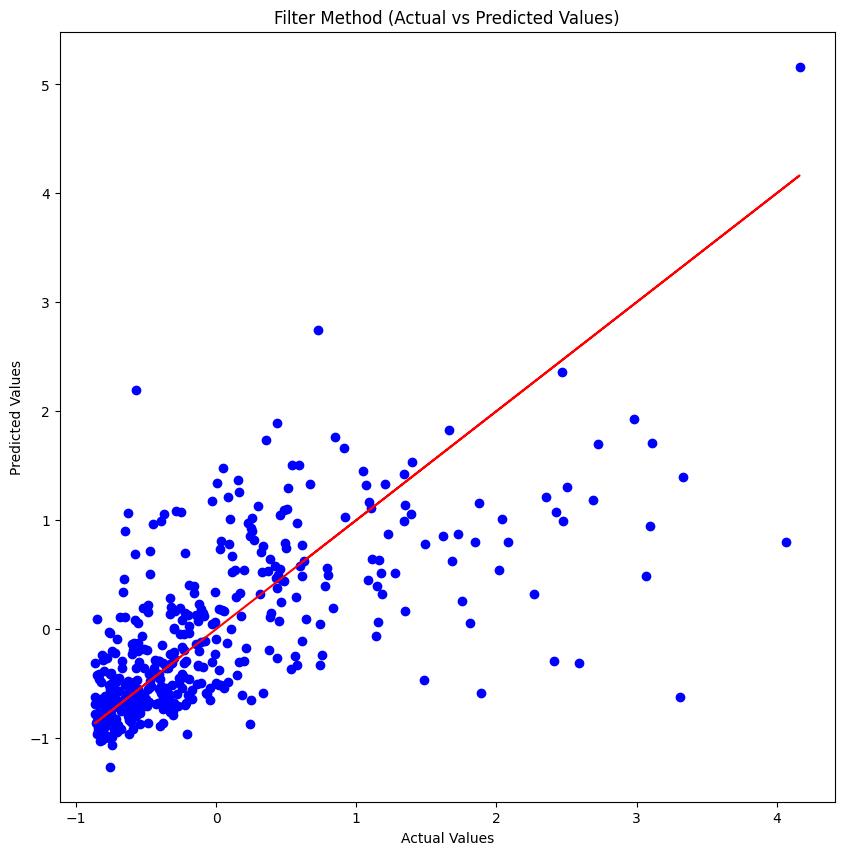

In [ ]:
# Import the mean_squared_error function
from sklearn.metrics import mean_squared_error

# Compute the Mean Squared Error (MSE) for the filter method
mse_flt = mean_squared_error(y_test, y_pred_flt)

# Print the Mean Squared Error (MSE) for the filter method
print("Mean Squared Error (MSE) for the filter method:", mse_flt)

# Plot the predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_flt, color='blue')
# Add a line for perfect correlation
plt.plot(y_test, y_test, color='red')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Filter Method (Actual vs Predicted Values)")
plt.show()


# 3. Wrapper methods
### Sequential Forward Selection (SFS)

The SFS is a method of feature selection in which we start with an empty set of features and add features one by one. At each iteration, we analyze the performance of the model with the added feature and select the best feature based on a predefined criterion. The process continues until we tested all the features or reached a predefined number of features. The best number and combination of features are then selected based on the predefined criterion.

We redifine the MLPRegressor for SFS and SBS with early stopping parameters to avoid contining trying to fit the model if it is not improving. Furthermore, we set n_iter_no_change to avoid epochs with no changes.

We then define the sfs method using the SequentialFeatureSelector class from the mlxtend library. For SFS we set foward=True, which means we are using the forward selection method and we make sure that the k_features is set to 40, which is the maximum number of features we want to select. We are also evaluating the model using mse so we set scoring='neg_mean_squared_error' and cv=0, which means we are not using cross-validation.

In [98]:
# Import the SequentialFeatureSelector class
from mlxtend.feature_selection import SequentialFeatureSelector as SF

# Redefine the MLPRegressor with early stopping parameters to avoid contining trying to fit the model if it is not improving and n_iter_no_change to avoid epochs with no changes.
mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, early_stopping=True, n_iter_no_change=10)

# Define the Sequential Forward Selection (SFS)
sfs = SF(  mlp,
            k_features=40,
            forward=True,
            floating=False,
            scoring='neg_mean_squared_error',
            cv=0)

# Select the features using the Sequential Forward Selection
sfs = sfs.fit(X_train, y_train)
# Get the selected features after SFS
sfs_features = list(sfs.k_feature_names_)

# Print the size of the selected features
print("Number of Selected Features from SFS:", len(sfs_features))


Number of Selected Features from SFS: 40


### Sequential Backward Selection (SBS)

The SBS is similar to the SFS but in reverse, this is why when defining the SBS object, the forward parameter is set to False. The algorithm will start with all the features and remove them one by one until the desired number of features is reached or the performance metric stops improving. The SBS algorithm is useful when the dataset has a large number of features and you want to reduce the number of features to improve the model's performance.

However, can suffer from overfitting if the number of features is too high, and the model will not generalize well to unseen data.

In [99]:
# Define the Sequential Backward Selection (SBS) object
sbs = SF(mlp,
            k_features=40,
            forward=False,
            floating=False,
            scoring='neg_mean_squared_error',
            cv=0)

# Select the features using the Sequential Backward Selection
sbs = sbs.fit(X_train, y_train)

# Get the selected features after SBS
sbs_features = list(sbs.k_feature_names_)

# Print the size of the selected features
print("Number of Selected Features from SBS:", len(sbs_features))

Number of Selected Features from SBS: 40


### Discussion on SFS and SBS


**Simmilarities:**
- Both SFS and SBS are easy to implement as they involve iterative feature selection with additional or removal of features.
- They are both wrapper methods that use a predictive model to evaluate the feature subsets.
- They both use greedy search strategies to select features which may lead to suboptimal solutions. This is they are unable to see the bigger picture and may not be optimal.

**Strengths of SFS:**
- SFS is computationally less expensive compared to exhaustive search methods.
- It is useful when the number of features is large, as it incrementally adds features that improve the model.

**Limitations of SFS:**
- SFS can get stuck in local optima, as it does not consider removing features once added.
- It may include redundant features that do not contribute significantly to the model's performance.

**Strengths of SBS:**
- SBS can remove irrelevant or redundant features, potentially leading to a more compact and interpretable model.
- It can be useful when the initial feature set is large and contains many irrelevant features.

**Limitations of SBS:**
- SBS is computationally more expensive than SFS, as it starts with all features and removes them one by one.
- It may remove features that are individually weak but collectively strong, leading to suboptimal feature subsets.


### Train Neural Networks

After defining the objects, we now select the features using the SFS and SBS gathered selected features. We then train the neural network using the selected features and predict the target feature on the test data. Finally, we compute the Mean Squared Error (MSE) for both the SFS and SBS selected features. Similarly, we plot the predicted vs actual values for the both to get an idea of how well the model is performing. 

Mean Squared Error with SFS:  0.4861747704698488


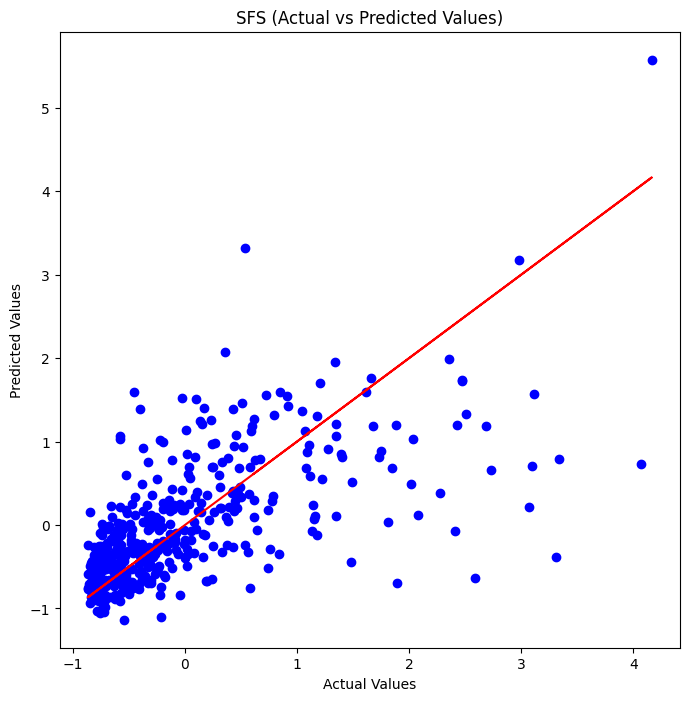

In [100]:
# Get the selected features after SFS for training and testing
X_test_sfs = X_test[sfs_features]
X_train_sfs = X_train[sfs_features]

# Train a neural network using SFS selected features
mlp_sfs = mlp.fit(X_train_sfs, y_train)
y_pred_sfs = mlp_sfs.predict(X_test_sfs)

# Compute the Mean Squared Error (MSE) for SFS
mse_sfs = mean_squared_error(y_test, y_pred_sfs)
print("Mean Squared Error with SFS: ", mse_sfs)

# Print the actual vs predicted values for SFS
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_sfs, color='blue')
plt.plot(y_test, y_test, color='red')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("SFS (Actual vs Predicted Values)")
plt.show()

### Train Neural Network with SBS Features
Similary we now also fit the model with the selected features of the sbs and calculate the mse.

Mean Squared Error with SBS:  0.435068882770359


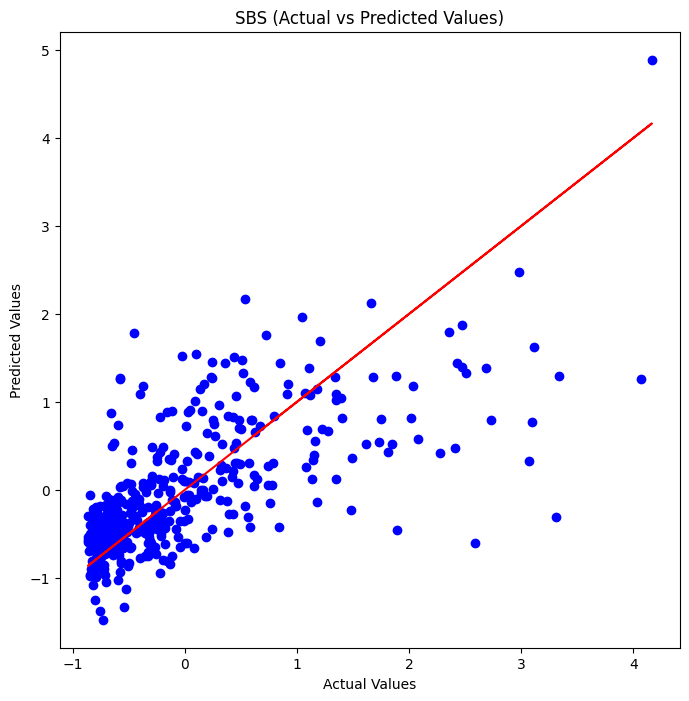

In [101]:
# Get the selected features after SBS for training and testing
x_test_sbs = X_test[sbs_features]
x_train_sbs = X_train[sbs_features]
# Train a neural network using SBS selected features
mlp_sbs = mlp.fit(x_train_sbs, y_train)
y_pred_sbs = mlp_sbs.predict(x_test_sbs)

# Compute the Mean Squared Error (MSE) for SBS
mse_sbs = mean_squared_error(y_test, y_pred_sbs)
print("Mean Squared Error with SBS: ", mse_sbs)

# Print the actual vs predicted values for SBS
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_sbs, color='blue')
plt.plot(y_test, y_test, color='red')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("SBS (Actual vs Predicted Values)")
plt.show()

## 4. Feature projection
### Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique that can be used to reduce the number of features in a dataset by calculating the variance of each feature and selecting the most important ones. The higher the variance in a feature the more important it is to explain the dataset.

Here we initialize a PCA object and fit it on the training data. We then plot the cumulative explained variance ratio to identify a reasonable number of components to select, where the curve starts to flatten out. 

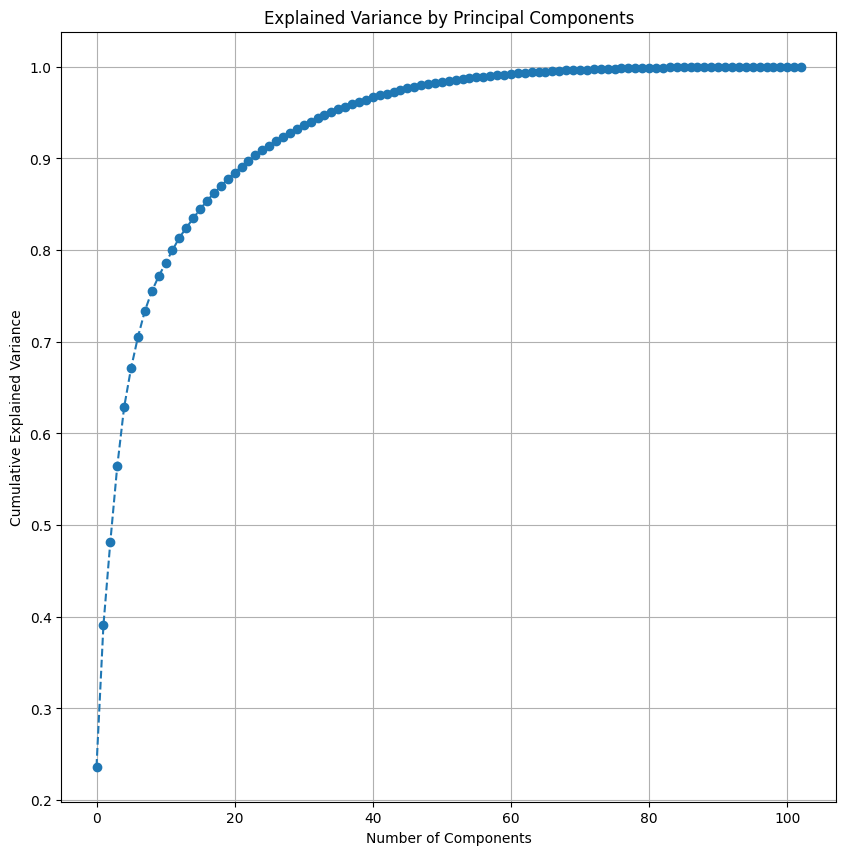

In [171]:
# Import the PCA class
from sklearn.decomposition import PCA

# Initialize a default PCA object
pca = PCA()

# Keeping the mlp the same for a fair comparison
mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, early_stopping=True, n_iter_no_change=10)

# Fit the PCA object on the dataset
pca.fit(X_train)

# Plot the explained variance ratio to be able to select the number of components
plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

### Select Cut-off Point
From the plot, we can see a linear logarithmic graph, explaining to use that as the number of components increases, the explained variance increases at a decreasing rate. From the graph, we can identify that around the 22nd component, we can explain around 90% of the variance in the dataset. This is a normal threshold trade-off between the number of components and the explained variance.

We then assign the selected components to a specific PCA object and fit the PCA object on the training data.

In [172]:

# Select the threshold for component selection
component_threshold = 22

# Assign the selected components to a specific PCA object
pca = PCA(n_components=component_threshold)


### Discussion on PCA

**Strengths of PCA:**
- PCA reduces the dimensionality of the dataset, which can lead to faster training times and reduced computational cost.
- It can help to remove noise and redundant features, potentially improving model performance.
- PCA can reveal the underlying structure of the data by identifying the principal components that explain the most variance.

**Limitations of PCA:**
- PCA is a linear method and may not capture complex, non-linear relationships in the data.
- The principal components may not have a clear interpretation, making it difficult to understand the impact of individual features.
- PCA requires the data to be standardized, which may not always be appropriate for all datasets.


### Train Neural Network with PCA Features
We can now transform and fit the training data, aswell as transform the test data. So that we can test the effectiveness of the PCA feature selection based on variance through a neural network.

We then compute the Mean Squared Error (MSE) for PCA and also the extra plot the actual vs predicted values for PCA.

Mean Squared Error with PCA:  0.47000999003825344


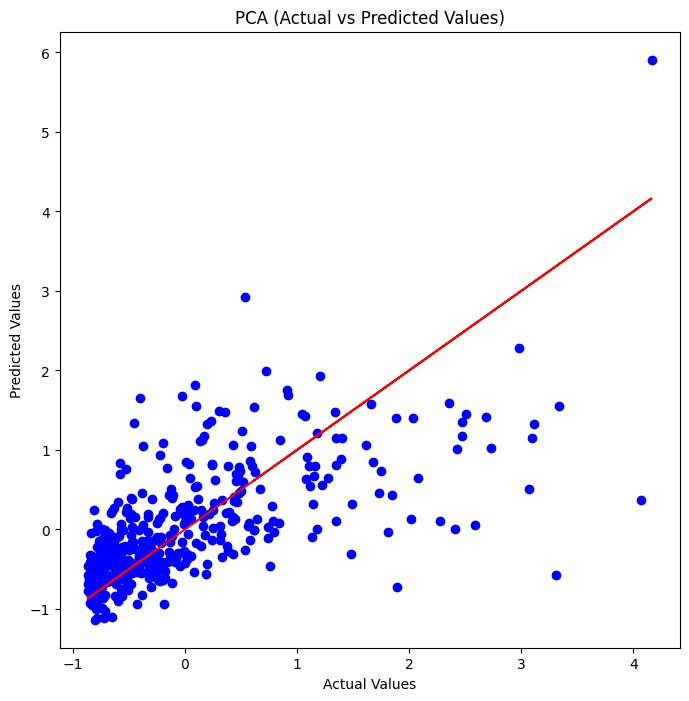

In [173]:
# Fit and transform the training data 
pca_train = pca.fit_transform(X_train)

# Transform the test data
pca_test = pca.transform(X_test)

# Train a neural network using PCA selected features
mlp_pca = mlp.fit(pca_train, y_train)

# Predict on the test set after fitting the model with PCA
pca_pred = mlp_pca.predict(pca_test)

# Compute the Mean Squared Error (MSE) for PCA
mse_pca = mean_squared_error(y_test, pca_pred)
print("Mean Squared Error with PCA: ", mse_pca)

# Plot the actual vs predicted values for PCA
plt.figure(figsize=(8, 8))
plt.scatter(y_test, pca_pred, color='blue')
plt.plot(y_test, y_test, color='red')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("PCA (Actual vs Predicted Values)")
plt.show()

# 5. Comparison

The MSE values are printed near each other for comparison and a simple bar chart is plotted to visualize the differences. The method with the lowest bar indicates the lowest MSE value and therefore the best feature selection method for this dataset. From graph it is clear that the SBS method has the lowest MSE value. ollowed by the filler method then the PCA method and finally the SFS method. Note altough we are ordering the methods by their MSE values, the difference between the methods is very small and could be different each time the models are trained and predicted on. All methods perform very well and reach close to optimal predictions and MSE values.

It was seen that both SBS and SFS reached the max number of features selected which was 40. This could be limiting the SFS method to select more features that could have improved the model. However this highlights one of its main flaws of being greedy and not considering the future information. 

The PCA method was able to reduce the dimensionality of the dataset while still maintaining the predictive power of the model. PCA shows to be a very good model if conserving computational power is a priority. 

The filter method using the corelation matrix showed to be more effective than expected, however, it makes sense as the corelation to the goal clearly identitfy the features that are more likely to be predictive.

Finally, we conclude that for this dataset the SBS method was the best feature selection method. This could be due to the large number of features in the dataset and the ability of the SBS method beeing able to remove less important ones whilst keeping the most important ones.

Mean Squared Error with Filter Method:  0.4640926666306293
Mean Squared Error with SFS:  0.4861747704698488
Mean Squared Error with SBS:  0.435068882770359
Mean Squared Error with PCA:  0.47000999003825344


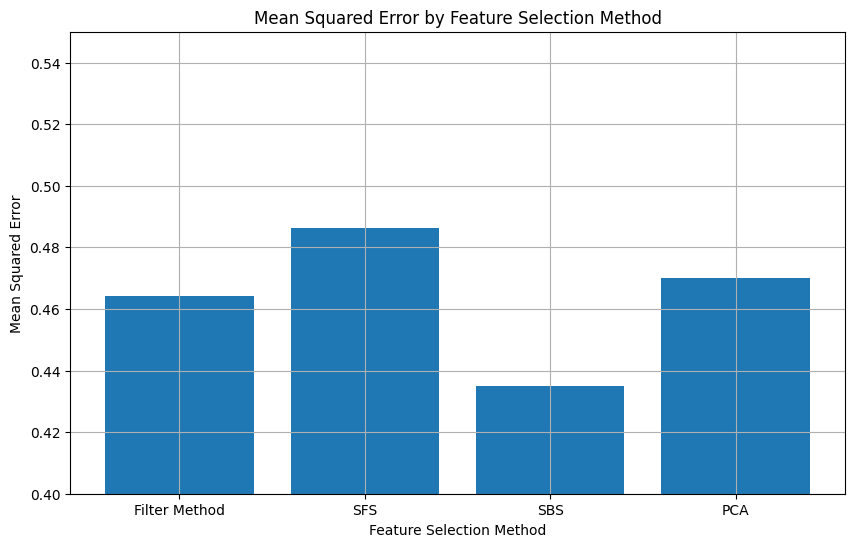

In [175]:
# Print the mse for all the methods
print("Mean Squared Error with Filter Method: ", mse_flt)
print("Mean Squared Error with SFS: ", mse_sfs)
print("Mean Squared Error with SBS: ", mse_sbs)
print("Mean Squared Error with PCA: ", mse_pca)

# Plot the mse for comparison in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(['Filter Method', 'SFS', 'SBS', 'PCA'], [mse_flt, mse_sfs, mse_sbs, mse_pca])
plt.xlabel('Feature Selection Method')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error by Feature Selection Method')
# Zoom in due to the small differences\
plt.ylim(0.4,0.55)
plt.grid(True)
plt.show()

## Plagiarism

- Use of GitHub Copilot for syntax aiding, especially when it came to plotting graphs.
- Use of the VS Code inbuilt function definition to understand the parameters of the functions used.
- Use of pandas documentation to understand data manipulation, including handling missing data: [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html)